In [1]:
# Python modules.
import os
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../data")


# Other modules.
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,  # Combat skewness
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    LinearRegression,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    root_mean_squared_error,
)
import neptune
import matplotlib.pyplot as plt
import seaborn as sns


# Library.
from src.utils import (
    prepare_submission,
    submit_file,
    get_submission_scores,
)


# Environment
# sns.set_theme("dark")

In [2]:
# Loading data
df_train = pd.read_csv("data/train.csv")
print(df_train.shape)
df_train_extra = pd.read_csv("data/training_extra.csv")
df_test = pd.read_csv("data/train.csv")
column_names = df_train.drop(columns=["id", "Price"]).columns

(300000, 11)


### EDA

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


<Figure size 1900x1000 with 0 Axes>

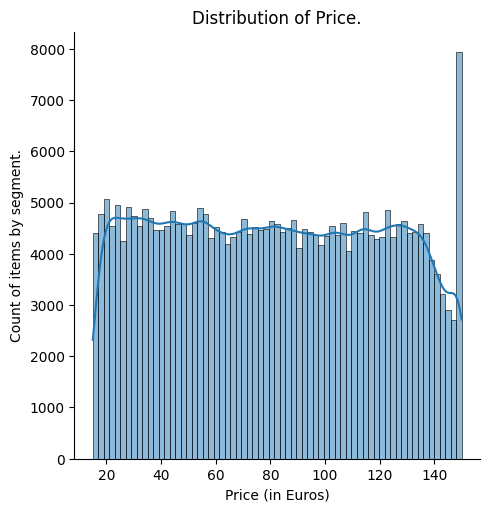

In [4]:
# Distribution of Price - What we want to predict.
plt.figure(figsize=(19, 10))
sns.displot(df_train, x="Price", kind="hist", kde=True)
plt.title("Distribution of Price.")
plt.xlabel("Price (in Euros)")
plt.ylabel("Count of items by segment.")
plt.show()

<Figure size 1900x1000 with 0 Axes>

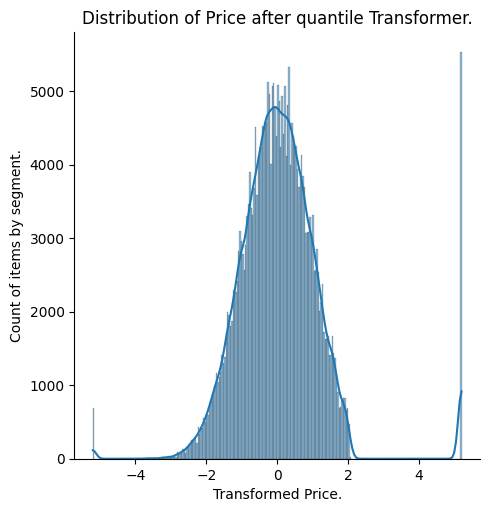

In [5]:
quan = QuantileTransformer(output_distribution="normal", n_quantiles=150)
df_train["normal_Price"] = quan.fit_transform(df_train.loc[:, ["Price"]])

# Distribution of Price - What we want to predict.
plt.figure(figsize=(19, 10))
sns.displot(df_train, x="normal_Price", kind="hist", kde=True)
plt.title("Distribution of Price after quantile Transformer.")
plt.xlabel("Transformed Price.")
plt.ylabel("Count of items by segment.")
plt.show()

### Computing standard deviation

/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/var/folders/zv/gdbn3s7n751brg9qr4h7x6fw0000gp/T/ipykernel_18426/3538648098.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sdt_dev_price = np.std(df_train.loc[:, ["Price"]])[0]


39.039275311505314


<Figure size 1900x1000 with 0 Axes>

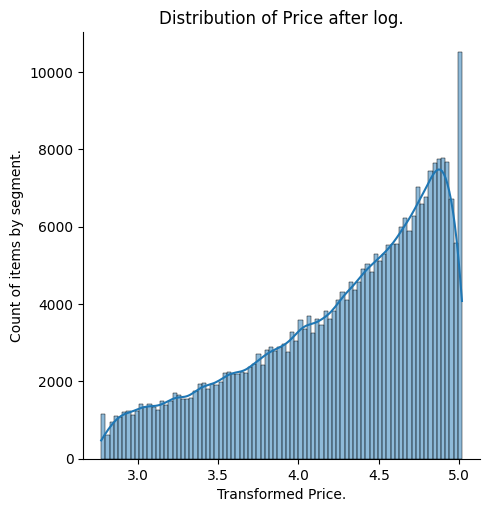

In [6]:
sdt_dev_price = np.std(df_train.loc[:, ["Price"]])[0]
print(sdt_dev_price)

tmp_df_train = df_train.copy()
tmp_df_train["Price_log"] = np.log1p(tmp_df_train.loc[:, ["Price"]])

# Distribution of Price - What we want to predict.
plt.figure(figsize=(19, 10))
sns.displot(tmp_df_train, x="Price_log", kind="hist", kde=True)
plt.title("Distribution of Price after log.")
plt.xlabel("Transformed Price.")
plt.ylabel("Count of items by segment.")
plt.show()

### Studying features.

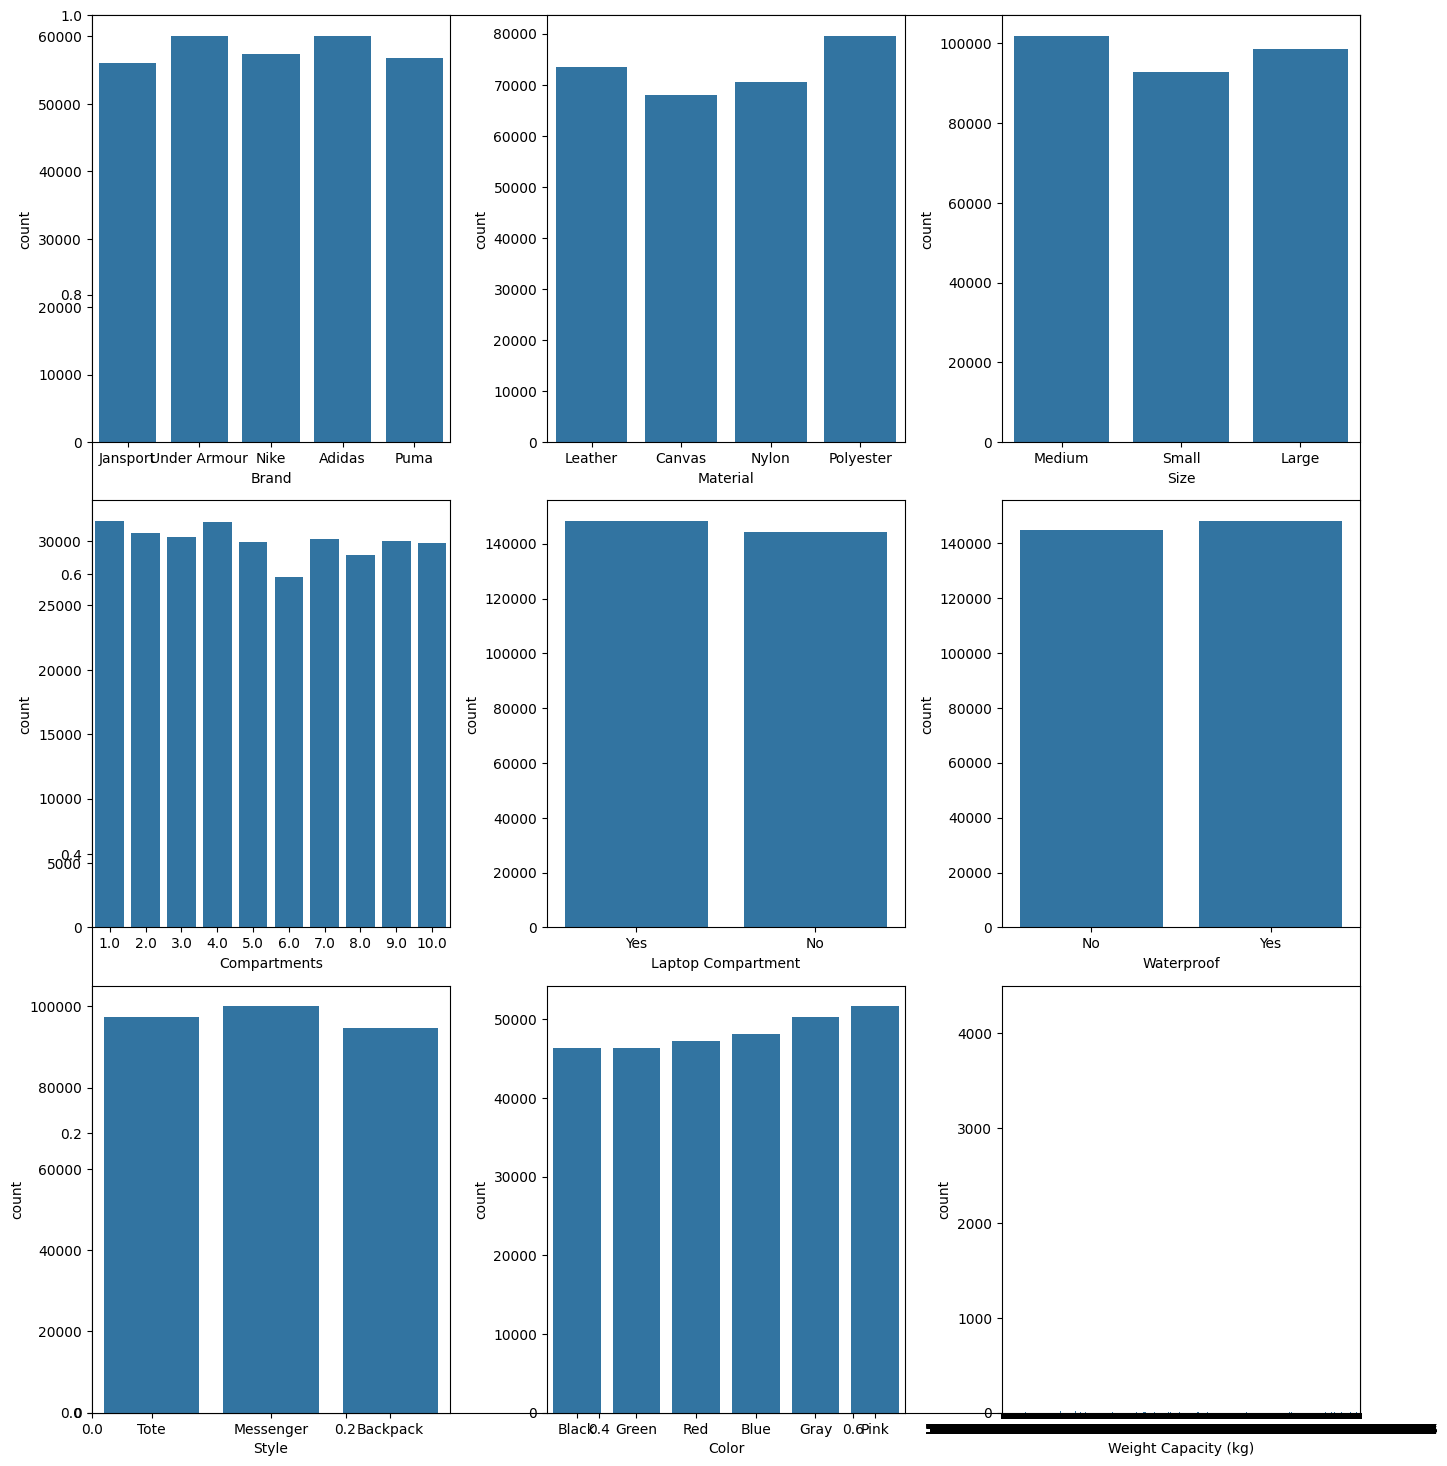

In [7]:
# Super long.

# Set the figure size for the subplots
plt.subplots(figsize=(15, 15))

# Loop through the specified columns
for i, col in enumerate(column_names):
    # Create subplots in a 3x2 grid
    plt.subplot(3, 3, i + 1)
    
    # Create a countplot for the current column
    sns.countplot(data=df_train, x=col)
    
# Adjust subplot layout for better presentation
plt.tight_layout()

# Display the subplots
plt.show()

After studying a bit the features, it appears to me that there is no fundamentall distinction between featrues. They do not seems to impact the price so much. Every time I make computation and get the mean price depending on Style, Material or whatever, I ended up having a 80-82 mean pricce.

Useless.

In [9]:
df_train.groupby(["Brand", "Material", "Style"]).agg({"Price": "mean"})

Price
Brand        Material  Style               
Adidas       Canvas    Backpack   81.634013
                       Messenger  81.692120
                       Tote       81.069860
             Leather   Backpack   79.304768
                       Messenger  80.387837
                       Tote       79.671287
             Nylon     Backpack   79.994290
                       Messenger  80.042028
                       Tote       80.021872
             Polyester Backpack   81.295030
                       Messenger  80.793140
                       Tote       81.250601
Jansport     Canvas    Backpack   82.514452
                       Messenger  82.000725
                       Tote       81.937196
             Leather   Backpack   81.910635
                       Messenger  80.322770
                       Tote       80.256659
             Nylon     Backpack   82.091486
                       Messenger  82.674412
                       Tote       82.074754
             Polyester Backpack   81.788767
                       Messenger  83.350857
                       Tote       81.482549
Nike         Canvas    Backpack   82.327011
                       Messenger  82.492024
                       Tote       81.929173
             Leather   Backpack   80.874444
                       Messenger  79.722102
                       Tote       80.584412
             Nylon     Backpack   80.363496
                       Messenger  80.852628
                       Tote       81.136438
             Polyester Backpack   80.982441
                       Messenger  82.022193
                       Tote       82.921463
Puma         Canvas    Backpack   81.293053
                       Messenger  81.758590
                       Tote       82.823583
             Leather   Backpack   80.564972
                       Messenger  80.852220
                       Tote       79.695995
             Nylon     Backpack   81.466188
                       Messenger  80.318627
                       Tote       81.075294
             Polyester Backpack   81.814347
                       Messenger  81.897673
                       Tote       82.214205
Under Armour Canvas    Backpack   83.418060
                       Messenger  82.476542
                       Tote       82.663583
             Leather   Backpack   80.397187
                       Messenger  80.985548
                       Tote       81.510694
             Nylon     Backpack   81.645616
                       Messenger  81.386811
                       Tote       80.791505
             Polyester Backpack   82.975729
                       Messenger  82.567535
                       Tote       82.604809

## Preprocessing

In [ ]:
# Preprocessing
def fillna(df: pd.DataFrame) -> pd.DataFrame:
    """Fillign na.
    Super simple rules.

    :param df:
    :return df:
    """
    # Object
    df["Brand"] = df["Brand"].fillna(value="Unknown")
    df["Material"] = df["Material"].fillna(value="Unknown")
    df["Size"] = df["Size"].fillna(value="Unknown")
    df["Laptop Compartment"] = df["Laptop Compartment"].fillna(value="No")
    df["Waterproof"] = df["Waterproof"].fillna(value="No")
    df["Style"] = df["Style"].fillna(value="Unknown")
    df["Color"] = df["Color"].fillna(value="Unknown")
    # Float
    df["Compartments"] = df["Compartments"].fillna(value=0.0)
    df["Weight Capacity (kg)"] = df["Weight Capacity (kg)"].fillna(value=0.0)
    return df

df_train_filled = fillna(df=df_train)
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 300000 non-null  object 
 2   Material              300000 non-null  object 
 3   Size                  300000 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    300000 non-null  object 
 6   Waterproof            300000 non-null  object 
 7   Style                 300000 non-null  object 
 8   Color                 300000 non-null  object 
 9   Weight Capacity (kg)  300000 non-null  float64
 10  Price                 300000 non-null  float64
 11  normal_Price          300000 non-null  float64
 12  Price_log             300000 non-null  float64
dtypes: float64(5), int64(1), object(7)
memory usage: 29.8+ MB


In [ ]:
scalers = {
    "object": {},
    "float64": {},
}
df_train_filled_n = df_train_filled.copy()
for column_name in df_train_filled_n.columns:
    if column_name == "id":
        continue
    if column_name == "normal_Price":
        enc = StandardScaler()
        df_train_filled_n[column_name] = enc.fit_transform(df_train_filled_n.loc[:, [column_name]])
        scalers["float64"][column_name] = enc
        continue
    if df_train_filled_n[column_name].dtype == "object":
        enc = LabelEncoder()
        df_train_filled_n[column_name] = enc.fit_transform(df_train_filled_n.loc[:, [column_name]])
        scalers["object"][column_name] = enc
    # elif df_train_filled_n[column_name].dtype == "float64":
    #     enc = MinMaxScaler()
    #     df_train_filled_n[column_name] = enc.fit_transform(df_train_filled_n.loc[:, [column_name]])
    #     scalers["float64"][column_name] = enc
    elif df_train_filled_n[column_name].dtype == "float64":
        enc = PowerTransformer()
        df_train_filled_n[column_name] = enc.fit_transform(df_train_filled_n.loc[:, [column_name]])
        scalers["float64"][column_name] = enc
    else:
        raise TypeError(f"{df_train_filled_n[column_name].dtype}")

df_train_filled_n.info()


/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 300000 non-null  int64  
 2   Material              300000 non-null  int64  
 3   Size                  300000 non-null  int64  
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    300000 non-null  int64  
 6   Waterproof            300000 non-null  int64  
 7   Style                 300000 non-null  int64  
 8   Color                 300000 non-null  int64  
 9   Weight Capacity (kg)  300000 non-null  float64
 10  Price                 300000 non-null  float64
 11  normal_Price          300000 non-null  float64
 12  Price_log             300000 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 29.8 MB


### Correlation matrix.

Text(0.5, 1.0, 'Correlation Matrix')

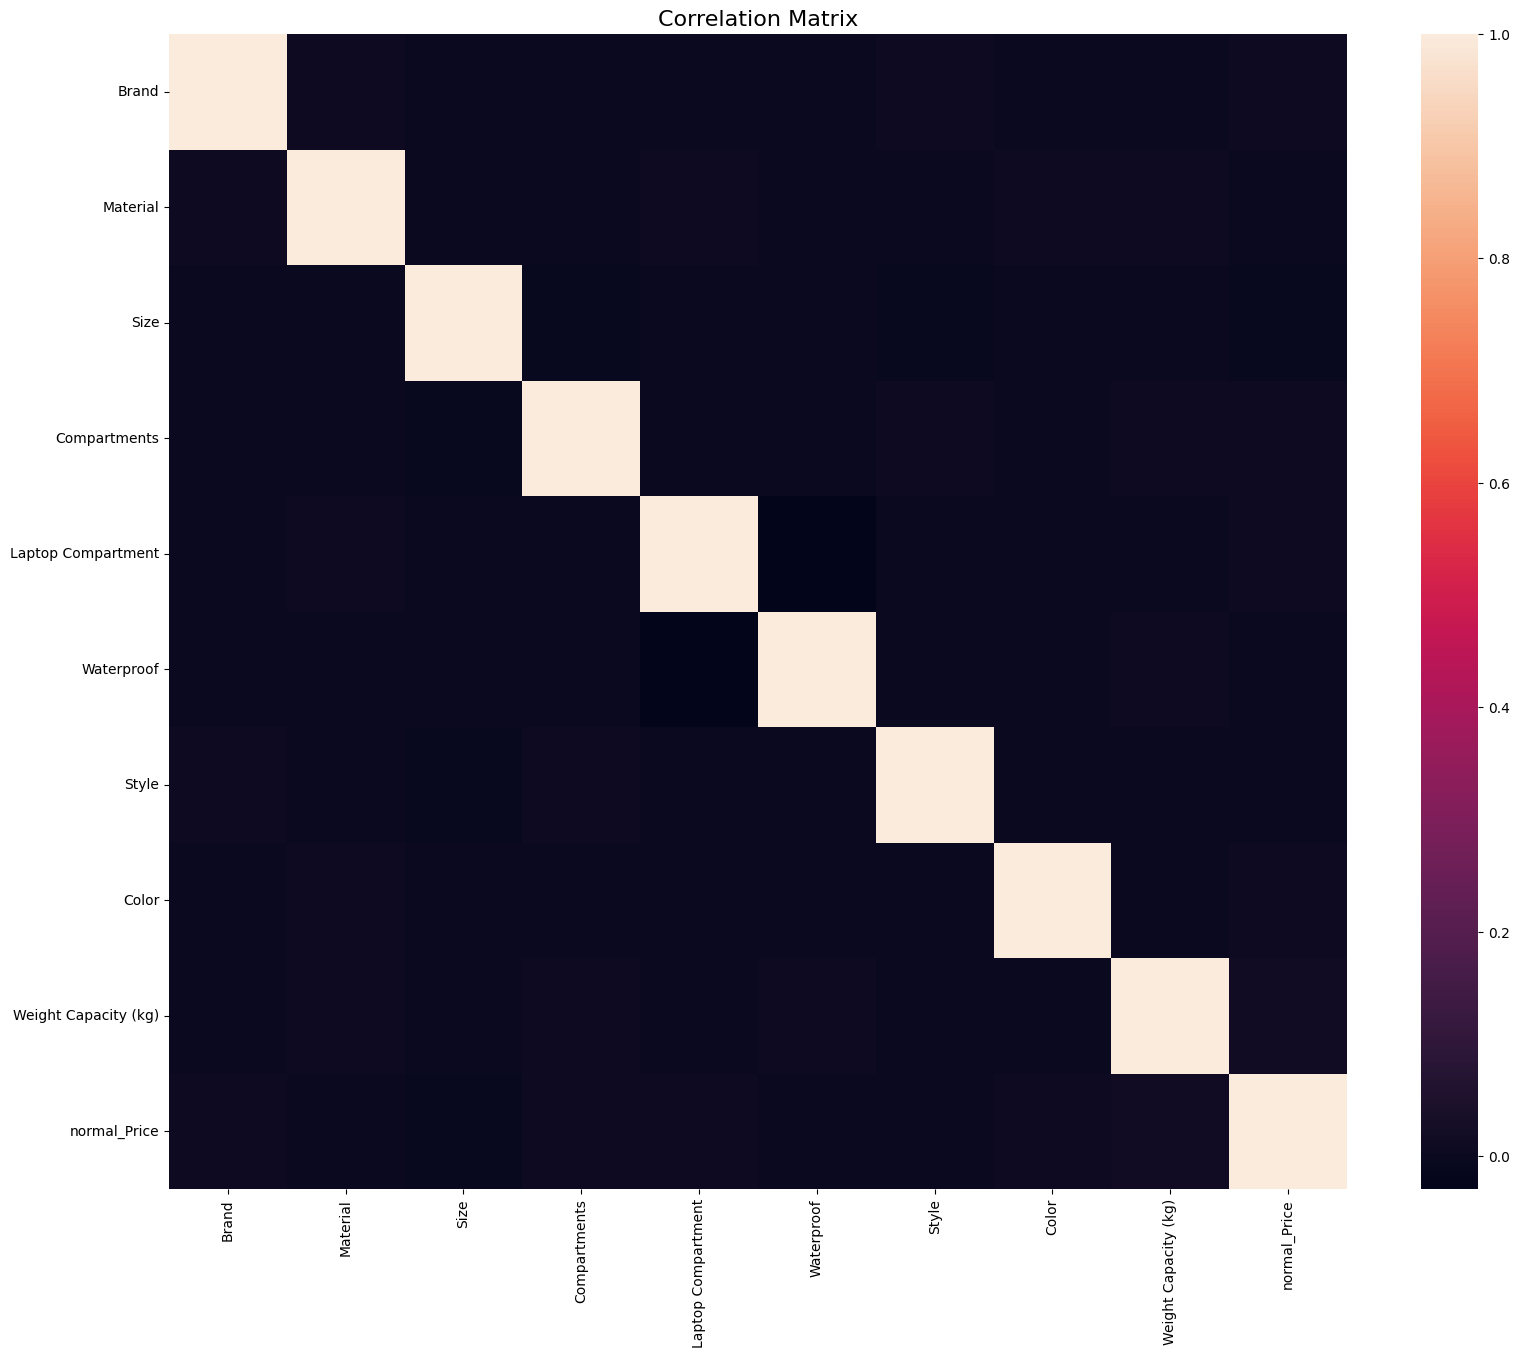

In [ ]:
f = plt.figure(figsize=(19, 15))
corr = (
    df_train_filled_n
    .select_dtypes(include=["float64", "int64"])
    .drop(columns=["Price", "id"])
    .corr()
)
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
)
plt.title('Correlation Matrix', fontsize=16)

In [ ]:
skew_values = df_train_filled_n.drop(columns=["id", "Price", "normal_Price"]).skew()
skew_values

Brand                  -0.001204
Material               -0.049950
Size                    0.032335
Compartments            0.026209
Laptop Compartment     -0.029142
Waterproof             -0.018551
Style                  -0.016077
Color                  -0.016593
Weight Capacity (kg)   -0.061997
dtype: float64

In [ ]:
X = df_train_filled_n.loc[:, column_names]
y = df_train_filled_n.loc[:, ["normal_Price"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
def get_lr_parameters():
    """To retrieve LR parameters."""
    lasso_setup = {
        "alpha": 0.1,      # L1 regularization strength
        "fit_intercept": True,
        "max_iter": 1000,  # Maximum iterations for convergence
        "tol": 0.0001,
        "selection": 'cyclic',
    }
    return {}

# Neptune.
# run = neptune.init_run(
#     project=os.environ["NEPTUNE_PROJECT"],
#     api_token=os.environ["NEPTUNE_KEY"],
# )

model = LinearRegression()
# model2 = Lasso(alpha=0.01)
# rf = RandomForestRegressor()
model.fit(X_train, y_train)
# model2.fit(X_train, y_train)
# rf.fit(X_train, y_train)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/picx/kaggle-swag-competition/e/KAG-25


/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [ ]:
score = model.score(X_test, y_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))
intercept = model.intercept_
coeff = model.coef_
# std_dev = np.std(y)
# score_l = model2.score(X_test, y_test)
# score_rf = rf.score(X_test, y_test)
# rmse_l = root_mean_squared_error(y_true=y_test, y_pred=model2.predict(X_test))
# rmse_rf = root_mean_squared_error(y_true=y_test, y_pred=rf.predict(X_test))
print(f"Score: {score:.2f}") # vs {score_l:.2f} vs {score_rf:.2f}")
print(f"RMSE: {rmse:.2f}") # vs {rmse_l:.2f} vs {rmse_rf:.2f}")

Score: 0.00 vs -0.00 vs -0.06
RMSE: 0.11 vs 0.11 vs 0.12


In [161]:
X_test["normal_Price_prediction"] = model.predict(X_test[column_names])
X_test["normal_Price"] = y_test.loc[:, ["normal_Price"]]
X_test

NameError: name 'model_rf' is not defined

In [97]:
# X_test["prediction_unscaled"] = quan.inverse_transform(X_test.loc[:, ["Price"]])
# y_test["Price"] = quan.inverse_transform(y_test.rename(columns={"normal_Price": "Price"}).loc[:, ["Price"]])
# X_test["real"] = y_test[["Price"]]
# X_test

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),prediction,prediction_2,prediction_unscaled,Price,real
56569,2,3,2,0.777778,1,0,0,0,0.769421,0.503688,0.038347,83.514075,0.038347,111.951146
883394,1,2,2,0.666667,1,0,0,5,0.869833,0.505348,0.055608,84.357467,0.055608,101.321184
555407,3,1,1,0.888889,1,0,0,5,0.404570,0.503543,0.036845,83.421015,0.036845,104.591087
239037,0,1,2,0.555556,0,0,2,5,0.662291,0.503160,0.032857,83.173926,0.032857,105.614800
1555852,2,1,0,0.222222,1,1,2,3,0.921310,0.508440,0.087762,86.011993,0.087762,109.975473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182334,2,0,2,0.888889,1,0,2,4,0.305315,0.501445,0.015026,82.150191,0.015026,106.285759
1174100,3,1,1,0.888889,1,1,0,3,0.224618,0.502128,0.022127,82.533699,0.022127,102.591009
1237071,3,3,1,0.333333,1,0,0,4,0.312483,0.502640,0.027455,82.839151,0.027455,112.731963
672131,0,3,1,0.777778,1,1,0,4,0.969833,0.507193,0.074799,85.354450,0.074799,111.627175


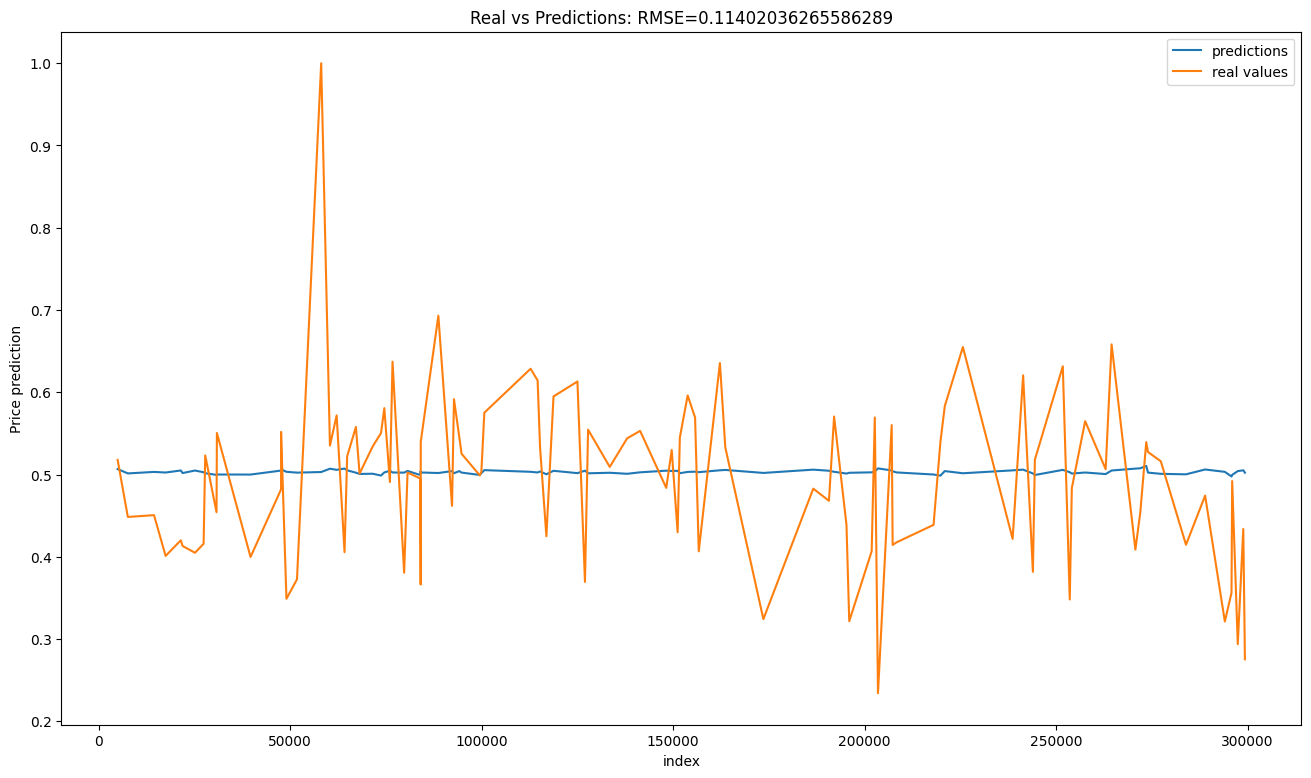

In [131]:
plt.figure(figsize=(16, 9))
sns.lineplot(
    data=X_test.reset_index().iloc[:100],
    x="index",
    y="normal_Price_prediction",
    label="predictions",
)
sns.lineplot(
    data=X_test.reset_index().iloc[:100],
    x="index",
    y="normal_Price",
    label="real values",
)
plt.title(f"Real vs Predictions: RMSE={rmse}")
plt.ylabel("Price prediction")
plt.show()

<Figure size 1900x1000 with 0 Axes>

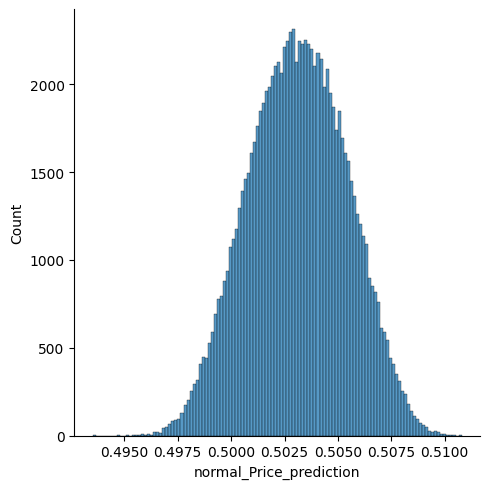

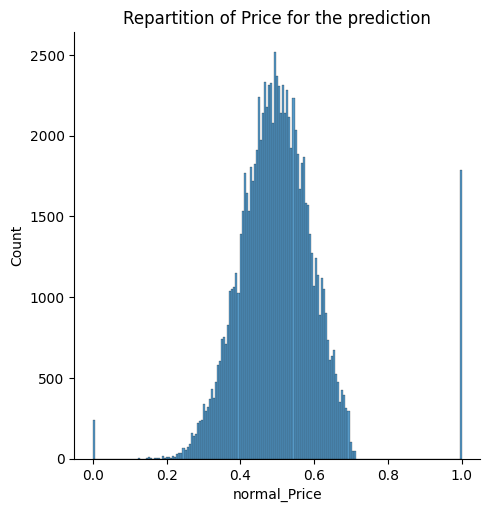

In [133]:
# Distribution of Price - What we want to predict.
plt.figure(figsize=(19, 10))
sns.displot(X_test, x="normal_Price_prediction", label="prediction")
sns.displot(X_test, x="normal_Price", label="real")
plt.title("Repartition of Price for the prediction")
plt.show()

In [ ]:
# Distribution of Price - What we want to predict.
plt.figure(figsize=(19, 10))
sns.displot(X_test, x="normal_Price_prediction")
plt.title("Repartition of Price for the prediction")
plt.show()

Linear regression is not a good model for this problem.

In [8]:
df_test_filled = fillna(df=df_test)
df_test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 300000 non-null  object 
 2   Material              300000 non-null  object 
 3   Size                  300000 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    300000 non-null  object 
 6   Waterproof            300000 non-null  object 
 7   Style                 300000 non-null  object 
 8   Color                 300000 non-null  object 
 9   Weight Capacity (kg)  300000 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [9]:
df_test_filled_n = df_test_filled.copy()
for column_name in df_test_filled_n.columns:
    if column_name == "id":
        continue
    if df_test_filled_n[column_name].dtype == "object":
        df_test_filled_n[column_name] = (
            scalers["object"][column_name]
            .fit_transform(df_test_filled_n.loc[:, [column_name]])
        )
    elif df_test_filled_n[column_name].dtype == "float64":
        df_test_filled_n[column_name] = (
            scalers["float64"][column_name]
            .fit_transform(df_test_filled_n.loc[:, [column_name]])
        )
    else:
        raise TypeError(f"{df_train_filled_n[column_name].dtype}")

df_test_filled_n.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 300000 non-null  int64  
 2   Material              300000 non-null  int64  
 3   Size                  300000 non-null  int64  
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    300000 non-null  int64  
 6   Waterproof            300000 non-null  int64  
 7   Style                 300000 non-null  int64  
 8   Color                 300000 non-null  int64  
 9   Weight Capacity (kg)  300000 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 25.2 MB


/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/

In [10]:
df_test_filled_n["prediction"] = model.predict(df_test_filled_n.loc[:, column_names])
df_test_filled_n["prediction"] = scalers["float64"]["Price"].inverse_transform(df_test_filled_n.loc[:, ["prediction"]])

In [11]:
df_test_filled_n

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,prediction
0,0,1,1,1,0.666667,1,0,2,0,0.387057,0.719694,80.992915
1,1,1,0,2,1.000000,1,1,1,3,0.902618,0.399115,80.937102
2,2,4,1,2,0.111111,1,0,1,5,0.554792,0.179061,81.736622
3,3,2,2,2,0.777778,1,0,1,3,0.431241,0.485985,81.243675
4,4,0,0,1,0.000000,1,1,1,3,0.591645,0.526097,80.985871
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,0,1,2,0.888889,0,0,2,1,0.424360,0.851833,80.637827
299996,299996,1,1,0,0.555556,0,1,2,1,0.887773,0.035987,81.316383
299997,299997,3,0,0,0.888889,1,1,0,4,0.396608,0.714175,81.890357
299998,299998,0,2,2,0.000000,0,1,2,4,0.205858,0.747339,80.937356


In [12]:
prepare_submission(df_predictions=df_test_filled_n)

Generating output: data/my_submission.csv.


In [13]:
submit_file(message="Only using Brand")

Submitting data/my_submission.csv to competition:playground-series-s5e2


100%|██████████| 2.29M/2.29M [00:01<00:00, 1.77MB/s]


Submission not allowed.
(400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Fri, 07 Feb 2025 15:23:06 GMT', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Origin': '*', 'Set-Cookie': 'ka_sessionid=babb25800f487332f8abbfd3a9ec7566; max-age=2626560; path=/, GCLB=CMzUnZ_Y1fyfIRAD; path=/; HttpOnly', 'Vary': 'Accept-Encoding', 'X-Kaggle-MillisecondsElapsed': '157', 'X-Kaggle-RequestId': '413209ea703872d3461fdd5fb9319eec', 'X-Kaggle-ApiVersion': '1.6.17', 'X-Kaggle-HubVersion': '0.3.7', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-TiygFC+vEtSnX7ph5QTH1A==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ 

In [171]:
get_submission_scores()

Retrieving scores from competition:playground-series-s5e2
42770810 - 40.92468 -  - 2025-02-08 11:06:30
42753436 - 90.27426 -  - 2025-02-07 14:09:37
42753425 -  -  - 2025-02-07 14:08:43
42753373 -  -  - 2025-02-07 14:05:28
42751414 - 47.83047 -  - 2025-02-07 11:28:51
42751405 - 61.44125 -  - 2025-02-07 11:27:19
42751147 - 39.16456 -  - 2025-02-07 11:01:47
42751114 - 39.16456 -  - 2025-02-07 10:59:07
